**How Spark runs on cluster**

Part 1 we have seens so far how the structured APIs take a logical operation, break it up into a logical plan, and  convert that to a physical plan that actually consists of Resilient Distributed Dataset (RDD) operations that execute across the cluster of machines.

**user-code**

The actual code that you write that defines your Spark Application

Each application is made up of one or more Spark jobs. Spark jobs within an application are executed serially (unless you use threading to launch
 multiple actions in parallel).



**SparkSession**

The first step of any Spark Application is creating a SparkSession. In many interactive modes, this is done for you, but in an application, you must do it manually

After you have a SparkSession, you should be able to run your Spark code.



Spark code essentially consists of transformations and actions
How you build these is up to you—whether it’s through SQL, low-level RDD
manipulation, or machine learning algorithms.

**How Spark takes your code and actually runs the commands on the cluster**


The first step is for you to submit an actual application.
You’re going to make a request to the cluster manager driver node

example; /bin/spark-submit \


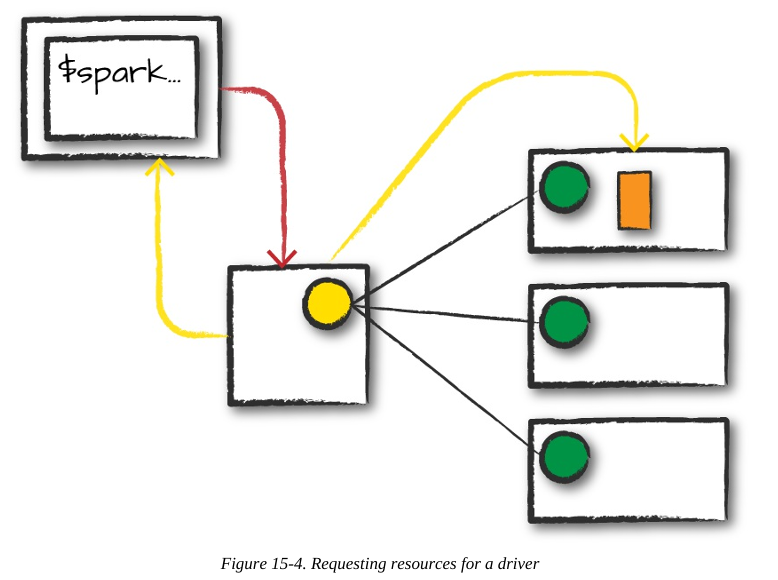

It begins running user code.This code must include a SparkSession that initializes a Spark cluster (e.g., driver + executors)


 The SparkSession will subsequently communicate with the cluster manager
 asking it to launch Spark executor processes across the cluster.

 The number of executors and their relevant configurations are set by the user




Spark goes about its merry way executing code. The driver and the workers communicate among themselves, executing code and moving data around. The driver schedules tasks onto each worker, and each worker responds with the status of those tasks and success or failure.

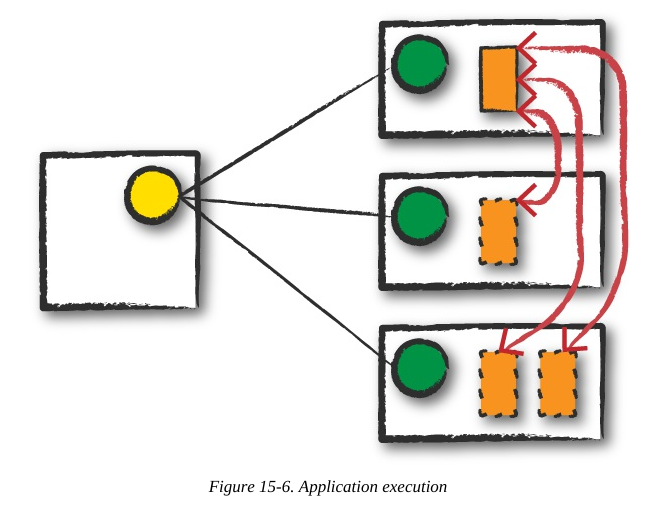

 After a Spark Application completes, the driver processs exits with either success or failure. The cluster manager then shuts down the executors in that Spark cluster for the driver.

 At this point, you can see the success or failure of the Spark Application by asking the cluster manager for this information



 **Logical instructions to physical execution**

 -   df1 = spark.range(2, 10000000, 2)
 -   df2 = spark.range(2, 10000000, 4)
 -   step1 = df1.repartition(5)
 -   step12 = df2.repartition(6)
 -   step2 = step1.selectExpr("id * 5 as id")
 -   step3 = step2.join(step12, ["id"])
 -   step4 = step3.selectExpr("sum(id)")
 -    step4.collect()

When we run this code, we can see that our action triggers one complete Spark job.

What we have when we call collect (or any action) is the execution of a Spark job that individually consist of **stages** and **tasks**.

**Spark Job**

In general, there should be one Spark job for one action.

Actions always return results.

Each job breaks down into a series of stages

The number of stages depends on how many shuffle operations need to take place.

The above codes(job) breaks into :
*  Stage 1 with 8 Tasks
*  Stage 2 with 8 Tasks
*  Stage 3 with 6 Tasks
*  Stage 4 with 5 Tasks
*  Stage 5 with 200 Tasks
*  Stage 6 with 1 Task

# **Stages**

Stages in Spark represent groups of tasks that can be executed together to compute the same operation on multiple machines

In general, Spark will try to pack as much work as possible (i.e.,
 as many transformations as possible inside the job) into the same stage, but the engine starts new stages after operations called shuffles.

**Shuffle**

A shuffle represents a physical repartitioning of the data

For example: sorting a DataFrame, grouping data

Repartitioning requires coordinating across executors to move data around.

Spark starts a new stage after each shuffle, and keeps track of what order the stages must run in to compute the final result

As given in above job:

*  df1 = spark.range(2, 10000000, 2)
*  df2 = spark.range(2, 10000000, 4)

*  Stage 1 with 8 Tasks
*  Stage 2 with 8 Tasks

Correspond to the range that we perform in order to create your DataFrames
-  step1 = df1.repartition(5)
-  step12 = df2.repartition(6)

* Stage 3 with 6 Tasks
* Stage 4 with 5 Tasks

The next step is the repartitioning. This changes the number of partitions by
 shuffling the data. These DataFrames are shuffled into 6 partitions and 5 partitions, corresponding to the number of tasks in stages 3 and 4.

 -  step3 = step2.join(step12, ["id"])
*  Stage 5 with 200 Tasks

 Shuffle, we have 200 tasks. This is because of a Spark SQL configuration. The
 spark.sql.shuffle.partitions default value is 200, which means that when there is a shuffle performed during execution, it outputs 200 shuffle partitions by default.

 We can change this value and the number of output partitions will change.
 spark.conf.set("spark.sql.shuffle.partitions", 50)

**Note**:A good rule of thumb is that the number of partitions should be larger than the number of executors on the cluster, potentially by multiple factors depending on the workload

*  step4.collect()

*  Stage 6 with 1 Task

Regardless of the number of partitions, the entire stage is computed in parallel. The final result aggregates those partitions individually, brings them all to a single partition before finally sending the final result
to the driver.

# **Tasks**

Stages in Spark consist of tasks. Each task corresponds to a combination of blocks of data and a set of transformations that will run on a single executor. If there is one big partition in our dataset, we will have one task.

If there are 1,000 little partitions, we will have 1,000 tasks that can be executed in parallel

A task is just a unit of computation applied to a unit of data (the
 partition).

Partitioning data into a greater number of partitions means that more can be
tasks executed in parallel.

This is not a panacea but it is a simple place to begin with optimization

Spark automatically pipelines stages and tasks that can be done together

**Pipelining**

Spark performs as many steps as it can at one point in time before writing data to memory or disk

Pipelining occurs at and below the RDD level.

With pipelining, any sequence of operations that feed data directly into each other, without needing to move it across nodes, is collapsed into a single stage of tasks that do all the operations together

**Note**
From a practical point of view, pipelining will be transparent as we write an application.The Spark runtime will automatically do it. We will see it when we inspect our application through the Spark UI or through its log files, where we will see that multiple RDD or DataFrame operations were pipelined into a single stage.

**Shuffle Persistence**

Shuffle persistence is that running a new job over data that’s already been shuffled does not rerun the “source” side of the shuffle. Because the shuffle files were already written to disk earlier, Spark knows that it can use them to run the later stages of the job, and it need not redo the earlier ones.

 In the Spark UI and logs, we will see the preshuffle stages marked as "skipped”. This automatic optimization can save time in a workload that runs multiple jobs over the same data

 This automatic optimization can save time in a workload that runs multiple jobs over the same data. But of course, for even better performance we can
 perform our own caching with the DataFrame or RDD cache method, which lets us control exactly which data is saved and where
